In [19]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

Данная цепь Маркова симулирует вероятности поездки пассажира между городами России.

In [20]:
states = ["Москва", "Санкт-Петербург", "Новосибирск", "Екатеринбург"]

# Матрица переходных вероятностей
P = np.array([
    [0.6, 0.2, 0.15, 0.05],
    [0.3, 0.5, 0.1, 0.1],
    [0.4, 0.1, 0.2, 0.3],
    [0.1, 0.2, 0.3, 0.4]
])

# Проверка, что строки суммируются до 1
print("Суммы строк матрицы P:", P.sum(axis=1))

df = pd.DataFrame(P, columns=states, index=states)
print(df)

Суммы строк матрицы P: [1. 1. 1. 1.]
                 Москва  Санкт-Петербург  Новосибирск  Екатеринбург
Москва              0.6              0.2         0.15          0.05
Санкт-Петербург     0.3              0.5         0.10          0.10
Новосибирск         0.4              0.1         0.20          0.30
Екатеринбург        0.1              0.2         0.30          0.40


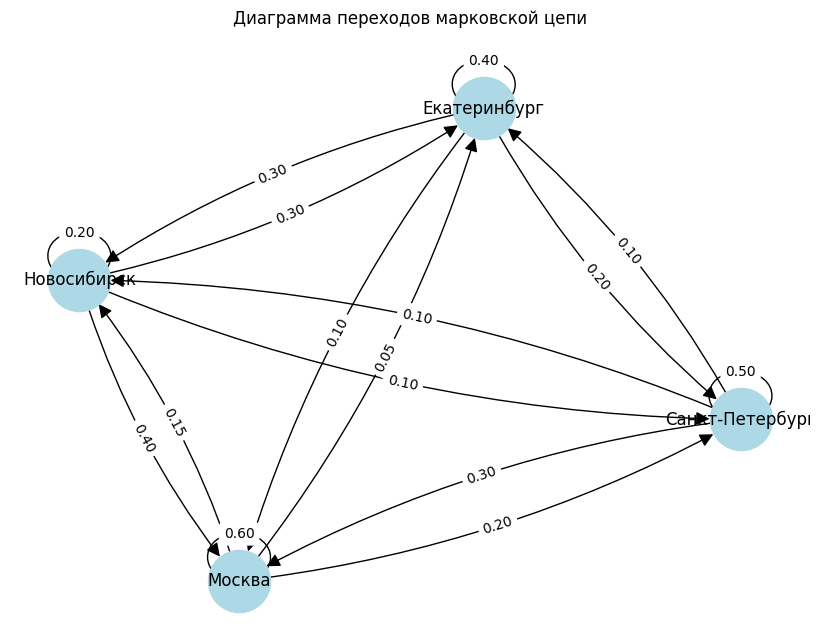

In [21]:
def draw_transition_diagram(states, P):
    G = nx.MultiDiGraph()
    for state in states:
        G.add_node(state)
    for i, state in enumerate(states):
        for j, next_state in enumerate(states):
            prob = P[i, j]
            if prob > 0:
                G.add_edge(state, next_state, weight=prob, label=f"{prob:.2f}")

    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, arrowsize=20, connectionstyle="arc3,rad=0.1")
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, connectionstyle="arc3,rad=0.1")
    plt.title("Диаграмма переходов марковской цепи")
    plt.show()


draw_transition_diagram(states, P)

In [22]:
def simulate_chain(P, initial_vector, epsilon=1e-6, max_steps=1000):
    current = initial_vector.copy()
    history = [current.copy()]
    rms_errors = []

    for step in range(max_steps):
        new = np.dot(current, P)
        # Вычисление среднеквадратичного отклонения между итерациями
        rms = np.sqrt(np.mean((new - current) ** 2))
        rms_errors.append(rms)
        history.append(new.copy())
        if rms < epsilon:
            break
        current = new
    return np.array(history), rms_errors

In [23]:
# Зададим несколько различных начальных векторов:
initial_vectors = {f"Начало в {state}": np.eye(len(states))[i] for i, state in enumerate(states)}

# Для хранения результатов моделирования
sim_results = {}

# Моделирование для каждого начального вектора
for label, init_vec in initial_vectors.items():
    history, rms_errors = simulate_chain(P, init_vec, epsilon=1e-6, max_steps=1000)
    sim_results[label] = {
        "history": history,
        "rms_errors": rms_errors,
        "final_vector": history[-1]
    }
    print(f"{label}: достигнуто за {len(history) - 1} шагов, финальный вектор: {history[-1]}")

Начало в Москва: достигнуто за 16 шагов, финальный вектор: [0.40644418 0.26146235 0.16976435 0.16232911]
Начало в Санкт-Петербург: достигнуто за 15 шагов, финальный вектор: [0.40644428 0.26146241 0.1697643  0.16232901]
Начало в Новосибирск: достигнуто за 16 шагов, финальный вектор: [0.40644306 0.26146205 0.16976477 0.16233012]
Начало в Екатеринбург: достигнуто за 17 шагов, финальный вектор: [0.40644304 0.26146205 0.16976478 0.16233013]


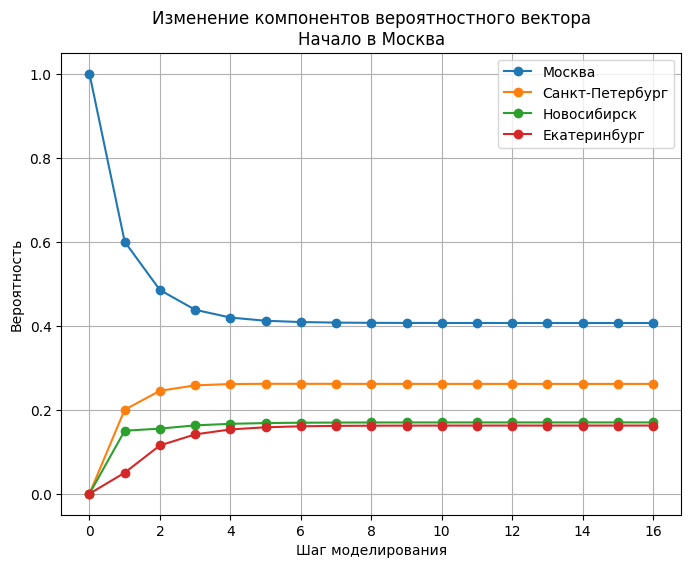

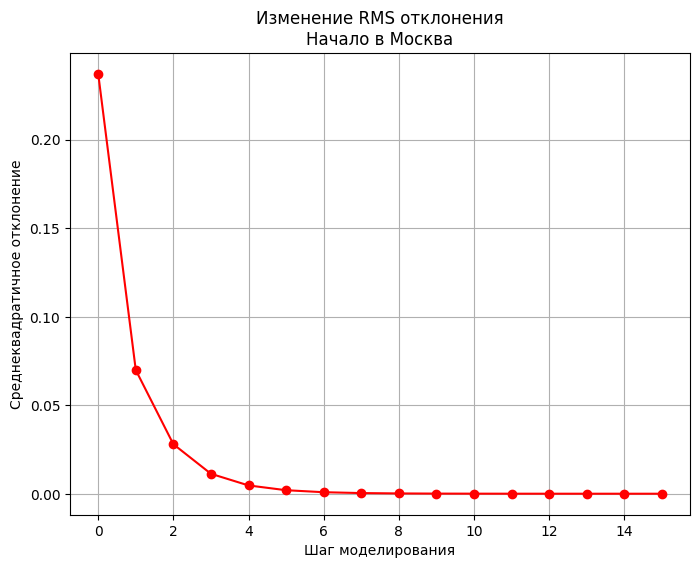

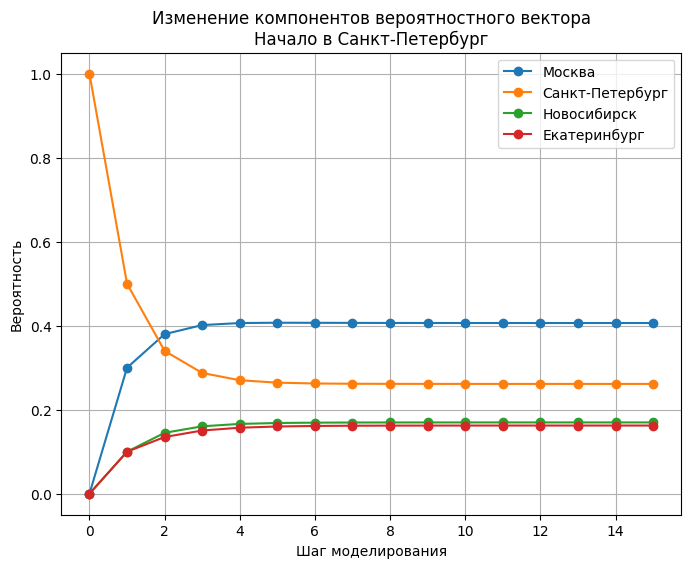

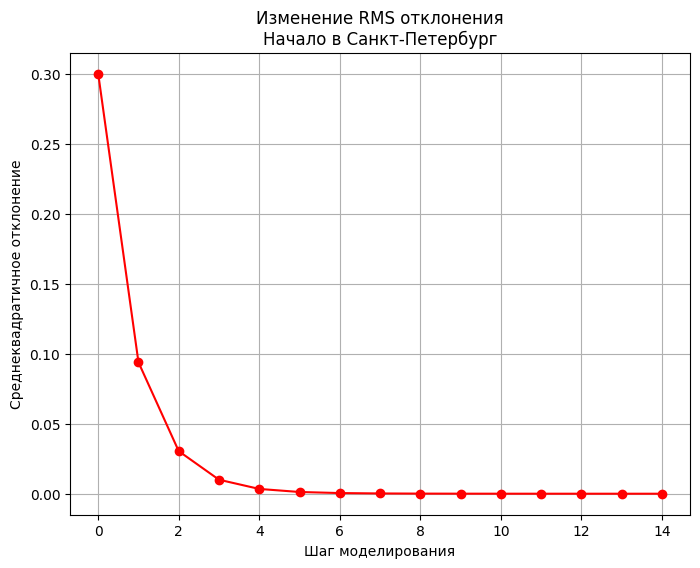

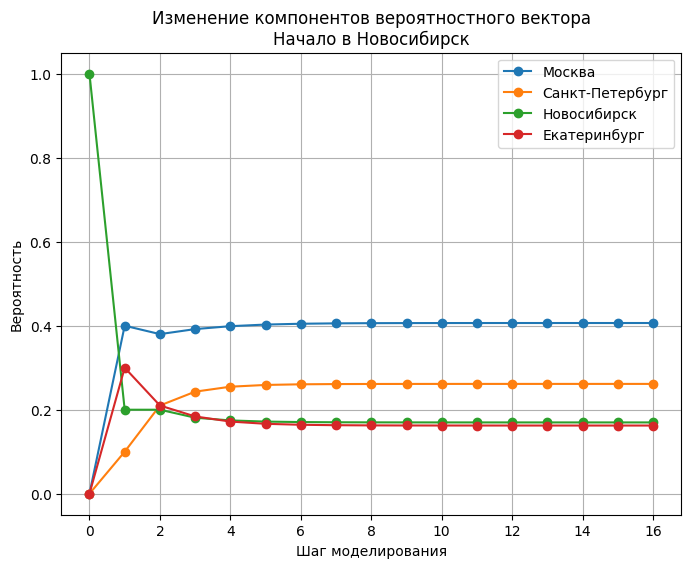

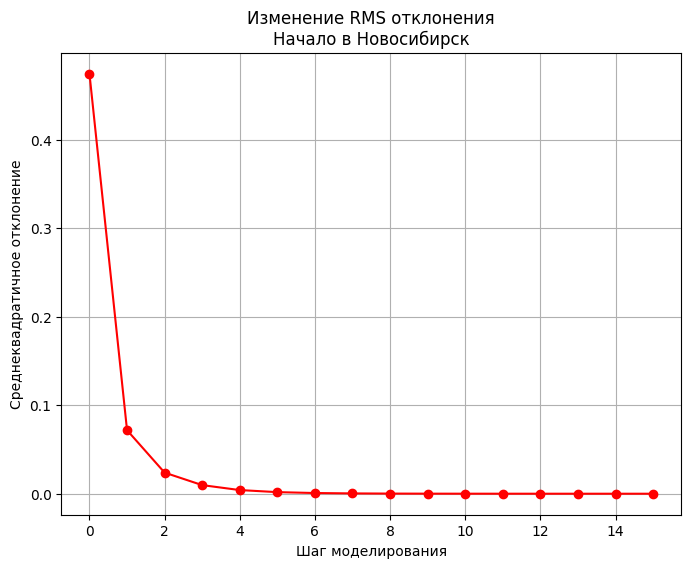

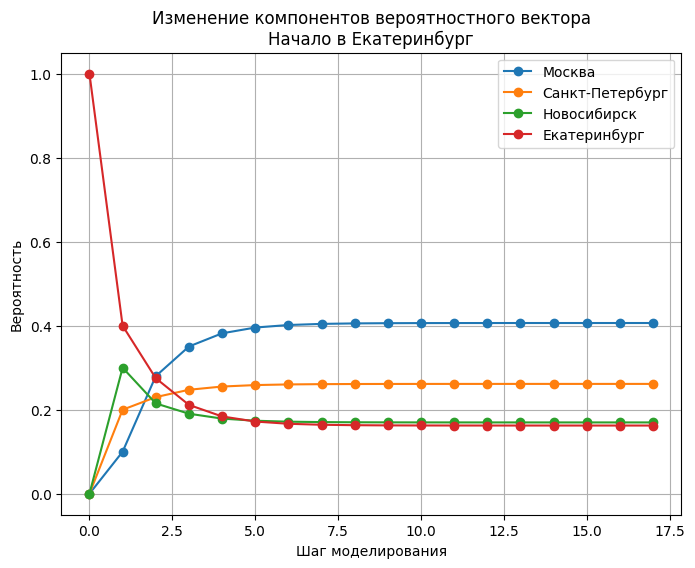

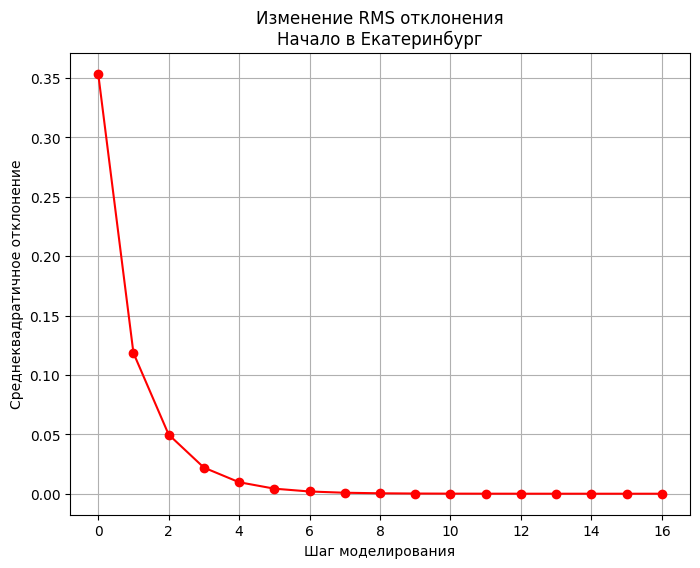

In [24]:
# Графики для каждого начального вектора: компоненты вероятностного вектора по шагам
for label, result in sim_results.items():
    history = result["history"]
    steps = np.arange(history.shape[0])

    plt.figure(figsize=(8, 6))
    for i, state in enumerate(states):
        plt.plot(steps, history[:, i], marker='o', label=state)
    plt.xlabel("Шаг моделирования")
    plt.ylabel("Вероятность")
    plt.title(f"Изменение компонентов вероятностного вектора\n{label}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # График изменения среднеквадратичного отклонения
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(len(result["rms_errors"])), result["rms_errors"], marker='o', color='red')
    plt.xlabel("Шаг моделирования")
    plt.ylabel("Среднеквадратичное отклонение")
    plt.title(f"Изменение RMS отклонения\n{label}")
    plt.grid(True)
    plt.show()

In [25]:
def stationary_distribution(P):
    n = P.shape[0]
    # Составляем систему уравнений: (P^T - I) * pi = 0, с дополнительным уравнением sum(pi)=1.
    A = P.T - np.eye(n)
    # Заменяем последнюю строку уравнения на уравнение суммы вероятностей
    A[-1, :] = np.ones(n)
    b = np.zeros(n)
    b[-1] = 1
    pi = np.linalg.solve(A, b)
    return pi

In [26]:
pi_analytical = stationary_distribution(P)
print("Аналитическое стационарное распределение:")
for state, prob in zip(states, pi_analytical):
    print(f"{state}: {prob:.4f}")

print("\nСравнение финальных векторов моделирования с аналитическим стационарным распределением:")
for label, result in sim_results.items():
    final_vec = result["final_vector"]
    diff = np.abs(final_vec - pi_analytical)
    print(f"\n{label}:")
    for state, sim_prob, pi_prob, d in zip(states, final_vec, pi_analytical, diff):
        print(f"  {state}: моделирование = {sim_prob:.4f}, аналитика = {pi_prob:.4f}, разница = {d:.4e}")


Аналитическое стационарное распределение:
Москва: 0.4064
Санкт-Петербург: 0.2615
Новосибирск: 0.1698
Екатеринбург: 0.1623

Сравнение финальных векторов моделирования с аналитическим стационарным распределением:

Начало в Москва:
  Москва: моделирование = 0.4064, аналитика = 0.4064, разница = 5.6570e-07
  Санкт-Петербург: моделирование = 0.2615, аналитика = 0.2615, разница = 1.4715e-07
  Новосибирск: моделирование = 0.1698, аналитика = 0.1698, разница = 2.1125e-07
  Екатеринбург: моделирование = 0.1623, аналитика = 0.1623, разница = 5.0161e-07

Начало в Санкт-Петербург:
  Москва: моделирование = 0.4064, аналитика = 0.4064, разница = 6.6100e-07
  Санкт-Петербург: моделирование = 0.2615, аналитика = 0.2615, разница = 2.0827e-07
  Новосибирск: моделирование = 0.1698, аналитика = 0.1698, разница = 2.6160e-07
  Екатеринбург: моделирование = 0.1623, аналитика = 0.1623, разница = 6.0767e-07

Начало в Новосибирск:
  Москва: моделирование = 0.4064, аналитика = 0.4064, разница = 5.6061e-07
  Санк

In [27]:
def city_forecast(days, start):
    print("Начатьное состояние: ", start)
    current_city = start
    path = [current_city]  # Список для хранения посещённых городов
    prob = 1.0            # Произведение вероятностей переходов

    for i in range(days):
        # Определяем индекс текущего города
        index = states.index(current_city)
        # Выбираем следующий город согласно вероятностям из соответствующей строки матрицы
        next_city = str(np.random.choice(states, replace=True, p=P[index]))
        # Вероятность данного перехода
        transition_prob = P[index, states.index(next_city)]
        prob *= transition_prob  # обновляем совокупную вероятность пути
        path.append(next_city)
        current_city = next_city

    print("Последовательность посещённых городов: " + str(path))
    print("Конечное состояние через " + str(days) + " дней: " + current_city)
    print("Вероятность выбранной последовательности: " + str(prob))

city_forecast(5, states[0])
city_forecast(10, states[1])

Начатьное состояние:  Москва
Последовательность посещённых городов: ['Москва', 'Екатеринбург', 'Новосибирск', 'Новосибирск', 'Екатеринбург', 'Новосибирск']
Конечное состояние через 5 дней: Новосибирск
Вероятность выбранной последовательности: 0.00027
Начатьное состояние:  Санкт-Петербург
Последовательность посещённых городов: ['Санкт-Петербург', 'Санкт-Петербург', 'Екатеринбург', 'Екатеринбург', 'Москва', 'Москва', 'Екатеринбург', 'Екатеринбург', 'Екатеринбург', 'Екатеринбург', 'Екатеринбург']
Конечное состояние через 10 дней: Екатеринбург
Вероятность выбранной последовательности: 1.536000000000001e-06
